# Writing an algorithm (using pure scientific Python)

In this notebook, we show how to write an algorithm for the NeuroFinder challenge using pure scientific Python. Elsewhere in the challenge we've used Thunder to define a standard format and API for inputs and outputs. Many of the algorithm examples have additionally used Spark and Thunder to manipulate the data and run analyses, but **this is not neccecssary**.

Here, we'll write a function that uses Thunder only for IO, and runs an algorithm purely using scientific Python libraries, like `numpy` and `skimage`.

## Load the data

This is the only step where we need Thunder (and the `ThunderContext` variable `tsc`), because we're using its API to load the images from Amazon S3

In [1]:
bucket = "s3n://neuro.datasets/"
path = "challenges/neurofinder/01.00/"
images = tsc.loadImages(bucket + path + 'images', startIdx=0, stopIdx=100)

## Write an algorithm

We need to write a function that takes an `images` variable as an input, as well as an `info` dictionary with data-set specific metadata, and returns identified sources as an output. The function will look like this:

In [3]:
def run(data, info=None):
    
    # do an analysis on the images
    
    # optionally make use of the metadata
    
    # return a set of sources
    
    pass

The `images` input is a class from Thunder, but we can convert it directly to a `numpy` array using the function `collectValuesAsArray`. 

NOTE: this will take a few seconds because we're loading the data here.

In [16]:
a = images.collectValuesAsArray()

In [17]:
a.shape

(100, 512, 512)

Now we have a numpy array! So long as we perform this same first step in our `run` function, we can write the rest of our algorithm using our favorite Python libraries: `numpy`, `scipy`, `sklearn`, `skimage`, etc. We do need to use Thunder's `SourceModel` at the end to wrap the output in the appropriate format at the end. Here's a very simple algorithm that just finds local maxima in the temporal standard deviation.

In [42]:
def run(data, info=None):
    
    # convert to array
    a = images.collectValuesAsArray()

    # compute the standard deviation over time
    s = a.std(axis=0)
    
    # extract local peaks
    from skimage.feature import peak_local_max
    peaks = peak_local_max(s, min_distance=10, num_peaks=100).tolist()
    
    # draw a circle around each peak
    from skimage.draw import circle
    from numpy import array
    def makecircle(center):
        rr, cc = circle(center[0], center[1], 5, a.shape[1:])
        return array(zip(rr, cc))
    circles = [makecircle(p) for p in peaks]
    
    # put list of coordinates into SourceModel
    from thunder import SourceModel
    return SourceModel([c for c in circles])

Run our function on the images

In [43]:
s = run(images)

In [44]:
s

SourceModel
100 sources

And use basic `matplotlib` to look at the result

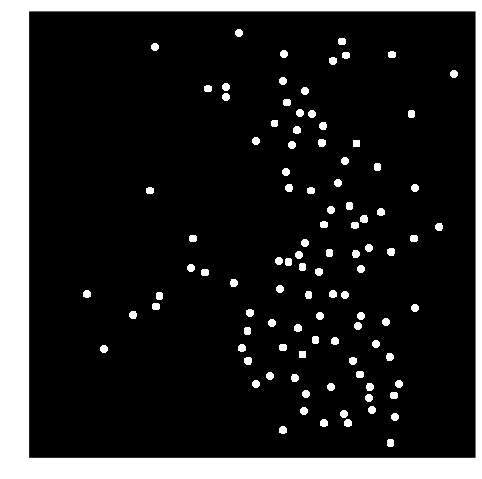

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
plt.imshow(s.masks((512,512)), cmap='Greys_r', interpolation='none')
plt.axis('off');

It's as easy as that! To speed up your testing workflow, we recommend loading the images into an array once (as we did above), write your function providing that array as the input, and just remember to add the `collectValuesAsArray` back in before submitting.

You could now follow the instructions [here](http://neurofinder.codeneuro.org/leaderboard/#submit) to submit this `run` function as your algorithm. Of course, we'd also want to check that it does a good job, but this should be enough to get you started.